In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
df = pd.read_csv('codon_usage.csv')

# REMOVAL OF ROWS WITH CORRUPTED DATASET COLUMNS (manually inspected)
# FIXING COLUMN DATATYPES
df = df.drop([486, 5063])
df = df.astype({'UUU': np.float64, 'UUC': np.float64})

# DATASET SUBSETS
all_df = df
euk_df = df[df['Kingdom'].isin(["pln","inv", "vrt", "mam", "rod","pri"])]
non_euk_df = df[~df['Kingdom'].isin(["pln","inv", "vrt", "mam", "rod","pri"])]

# CODON DATAFRAMES FOR MODEL TRAINING (dropping identification/target values)
codon_df = all_df.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID', 'DNAtype' ])
euk_codon_df = euk_df.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID', 'DNAtype' ])
non_euk_codon_df = non_euk_df.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID', 'DNAtype' ])

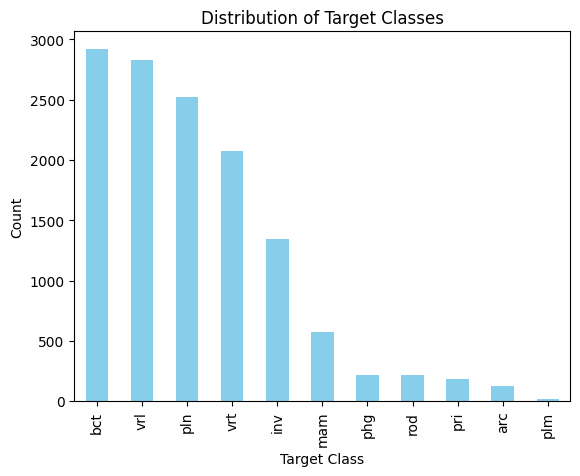

In [ ]:
target_counts = df['Kingdom'].value_counts()
target_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of Target Classes')

plt.show()

In [ ]:
target_counts = df['Kingdom'].value_counts()
target_counts.T

,count
Kingdom,
bct,2919
vrl,2831
pln,2523
vrt,2077
inv,1345
mam,572
phg,220
rod,215
pri,180


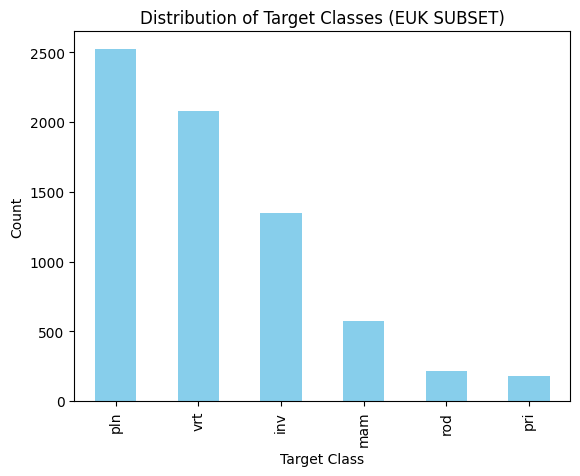

In [ ]:
target_counts = euk_df['Kingdom'].value_counts()
target_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of Target Classes (EUK SUBSET)')

plt.show()

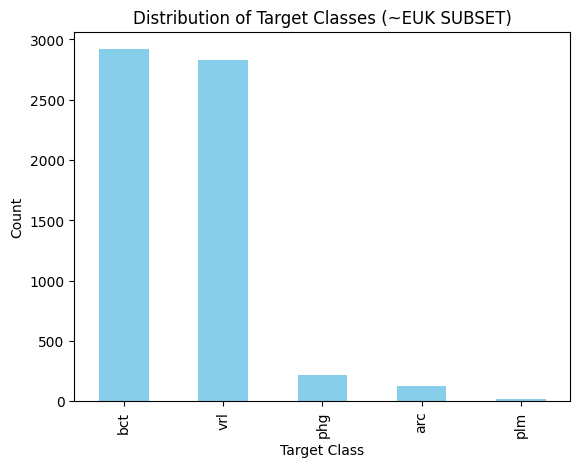

In [ ]:
target_counts = pro_df['Kingdom'].value_counts()
target_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of Target Classes (~EUK SUBSET)')

plt.show()

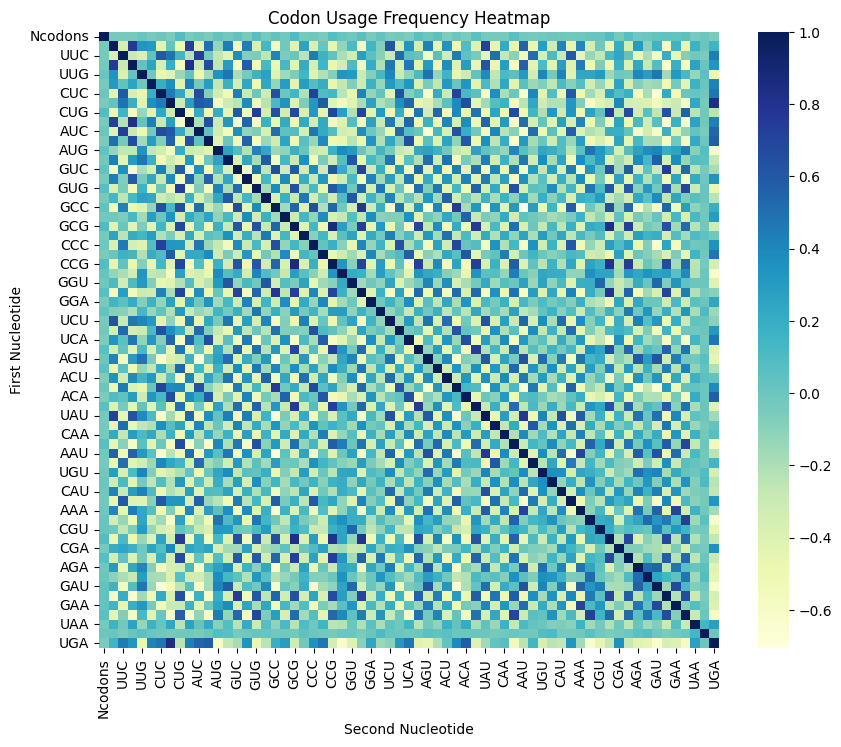

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(codon_df.corr(), fmt=".2f", cmap="YlGnBu")
plt.title("Codon Usage Frequency Heatmap")
plt.xlabel("Second Nucleotide")
plt.ylabel("First Nucleotide")
plt.show()

In [ ]:
X, y = codon_df, all_df['Kingdom']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

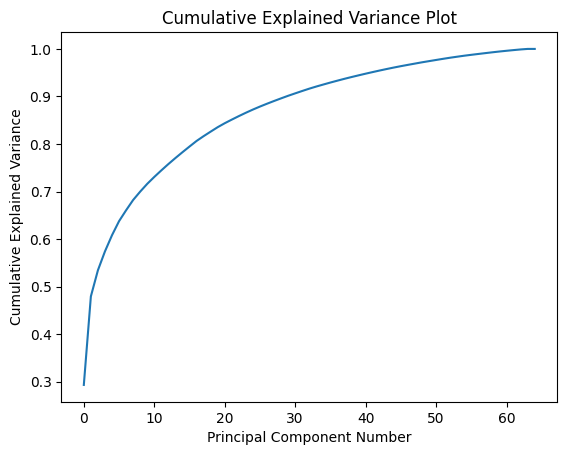

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Component Number")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot")
plt.show()

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)

42


In [ ]:
pca = PCA(n_components=42)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

In [ ]:
initial_feature_names = list(X)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(10)]
most_important_ev = [np.abs(pca.explained_variance_ratio_[i]) for i in range(10)]

most_important_names = [initial_feature_names[most_important[i]] for i in range(10)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(10)}

feature_importance_df = pd.DataFrame(dic.items())
feature_importance_df['2'] = most_important_ev
feature_importance_df.columns = ['Principal Component (PC)', 'Representative Codon', 'PC Explained Variance']
feature_importance_df

,Principal Component (PC),Representative Codon,PC Explained Variance
0,PC0,GGC,0.293256
1,PC1,CUA,0.186205
2,PC2,AGG,0.054969
3,PC3,GGU,0.039705
4,PC4,CUU,0.034015
5,PC5,CGA,0.029563
6,PC6,GCA,0.022922
7,PC7,GGA,0.021630
8,PC8,UAG,0.017590
9,PC9,UGC,0.016332


In [ ]:
reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         arc       0.00      0.00      0.00        23
         bct       0.23      1.00      0.38       604
         inv       0.00      0.00      0.00       291
         mam       0.00      0.00      0.00       112
         phg       0.00      0.00      0.00        46
         plm       0.00      0.00      0.00         5
         pln       0.00      0.00      0.00       495
         pri       0.00      0.00      0.00        40
         rod       0.00      0.00      0.00        40
         vrl       0.00      0.00      0.00       575
         vrt       0.00      0.00      0.00       375

    accuracy                           0.23      2606
   macro avg       0.02      0.09      0.03      2606
weighted avg       0.05      0.23      0.09      2606



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

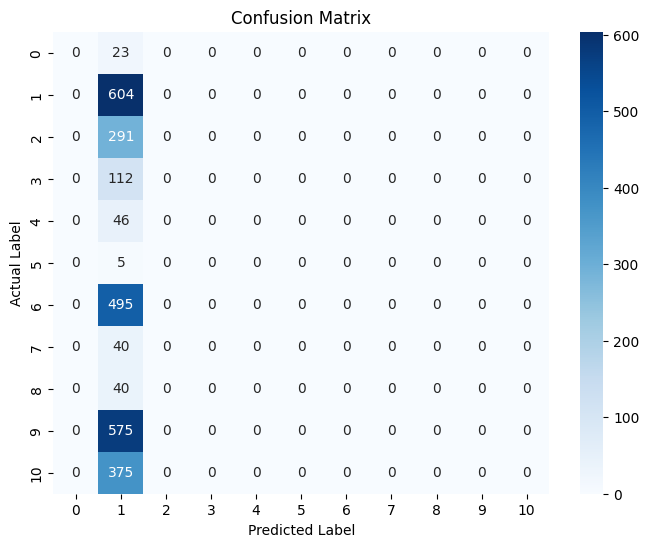

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # 'fmt='d' displays integers, 'annot=True' shows values in cells
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=False)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         arc       0.85      0.48      0.61        23
         bct       0.88      0.96      0.92       604
         inv       0.93      0.70      0.80       291
         mam       0.88      0.83      0.85       112
         phg       0.88      0.50      0.64        46
         plm       0.00      0.00      0.00         5
         pln       0.90      0.93      0.91       495
         pri       0.87      0.50      0.63        40
         rod       0.93      0.68      0.78        40
         vrl       0.89      0.96      0.93       575
         vrt       0.89      0.96      0.93       375

    accuracy                           0.89      2606
   macro avg       0.81      0.68      0.73      2606
weighted avg       0.89      0.89      0.89      2606



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


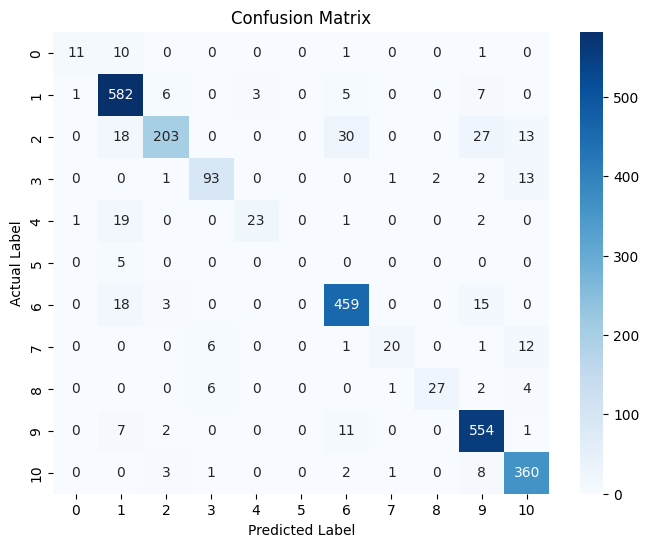

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # 'fmt='d' displays integers, 'annot=True' shows values in cells
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13026 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13026 non-null  object 
 1   DNAtype      13026 non-null  int64  
 2   SpeciesID    13026 non-null  int64  
 3   Ncodons      13026 non-null  int64  
 4   SpeciesName  13026 non-null  object 
 5   UUU          13026 non-null  float64
 6   UUC          13026 non-null  float64
 7   UUA          13026 non-null  float64
 8   UUG          13026 non-null  float64
 9   CUU          13026 non-null  float64
 10  CUC          13026 non-null  float64
 11  CUA          13026 non-null  float64
 12  CUG          13026 non-null  float64
 13  AUU          13026 non-null  float64
 14  AUC          13026 non-null  float64
 15  AUA          13026 non-null  float64
 16  AUG          13026 non-null  float64
 17  GUU          13026 non-null  float64
 18  GUC          13026 non-null  float64
 19  GUA      

In [ ]:
X, y = euk_codon_df, euk_df['Kingdom']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         inv       0.00      0.00      0.00       285
         mam       0.00      0.00      0.00       117
         pln       0.37      1.00      0.54       516
         pri       0.00      0.00      0.00        34
         rod       0.00      0.00      0.00        34
         vrt       0.00      0.00      0.00       397

    accuracy                           0.37      1383
   macro avg       0.06      0.17      0.09      1383
weighted avg       0.14      0.37      0.20      1383



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

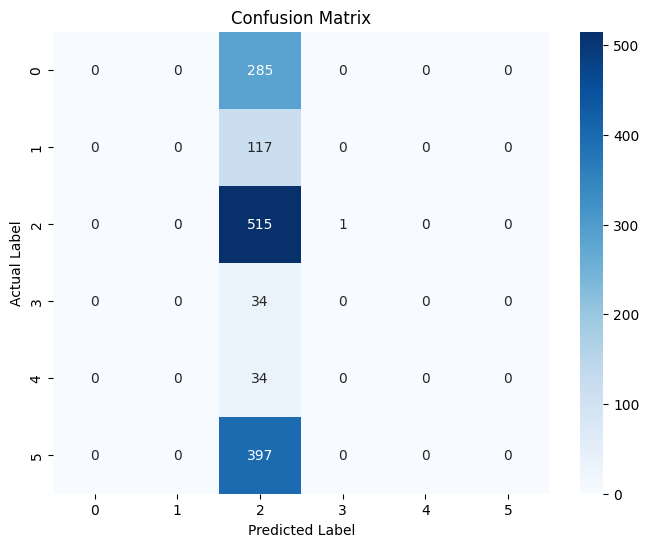

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # 'fmt='d' displays integers, 'annot=True' shows values in cells
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

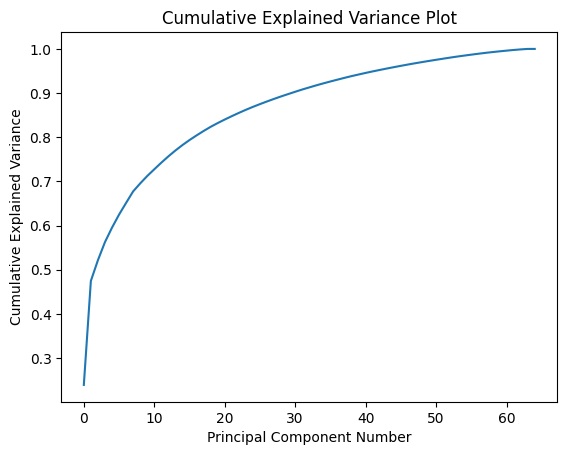

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Component Number")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot")
plt.show()

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)

43


In [ ]:
pca = PCA(n_components=43)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

In [ ]:
initial_feature_names = list(X)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(10)]
most_important_ev = [np.abs(pca.explained_variance_ratio_[i]) for i in range(10)]

most_important_names = [initial_feature_names[most_important[i]] for i in range(10)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(10)}

feature_importance_df = pd.DataFrame(dic.items())
feature_importance_df['2'] = most_important_ev
feature_importance_df.columns = ['Principal Component (PC)', 'Representative Codon', 'PC Explained Variance']
feature_importance_df

,Principal Component (PC),Representative Codon,PC Explained Variance
0,PC0,GAG,0.239086
1,PC1,GCC,0.235572
2,PC2,GCU,0.046825
3,PC3,GGG,0.041022
4,PC4,UGC,0.032745
5,PC5,GGA,0.029567
6,PC6,CAA,0.026520
7,PC7,GGG,0.026054
8,PC8,UAG,0.018002
9,PC9,CAA,0.016830


In [ ]:
rf = RandomForestClassifier(n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=False).fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         inv       0.91      0.82      0.86       285
         mam       0.91      0.83      0.87       117
         pln       0.92      0.97      0.95       516
         pri       1.00      0.65      0.79        34
         rod       0.91      0.62      0.74        34
         vrt       0.89      0.97      0.93       397

    accuracy                           0.91      1383
   macro avg       0.92      0.81      0.86      1383
weighted avg       0.91      0.91      0.91      1383



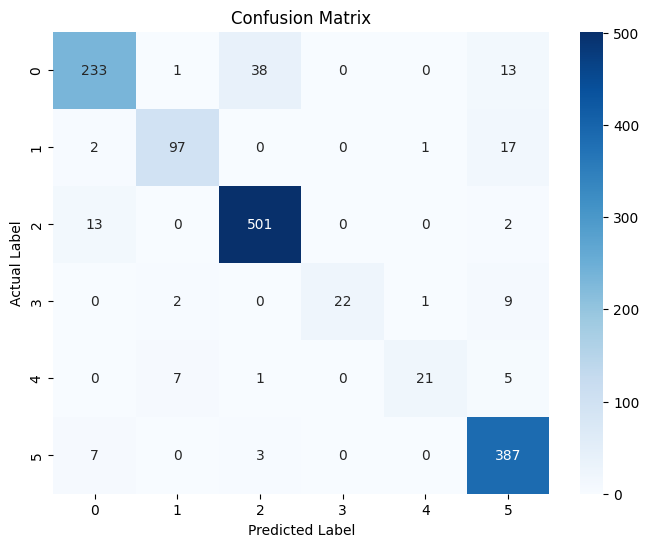

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # 'fmt='d' displays integers, 'annot=True' shows values in cells
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
euk_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6912 entries, 6114 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      6912 non-null   object 
 1   DNAtype      6912 non-null   int64  
 2   SpeciesID    6912 non-null   int64  
 3   Ncodons      6912 non-null   int64  
 4   SpeciesName  6912 non-null   object 
 5   UUU          6912 non-null   float64
 6   UUC          6912 non-null   float64
 7   UUA          6912 non-null   float64
 8   UUG          6912 non-null   float64
 9   CUU          6912 non-null   float64
 10  CUC          6912 non-null   float64
 11  CUA          6912 non-null   float64
 12  CUG          6912 non-null   float64
 13  AUU          6912 non-null   float64
 14  AUC          6912 non-null   float64
 15  AUA          6912 non-null   float64
 16  AUG          6912 non-null   float64
 17  GUU          6912 non-null   float64
 18  GUC          6912 non-null   float64
 19  GUA    

In [ ]:
X, y = pro_codon_df, pro_df['Kingdom']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         arc       0.00      0.00      0.00        30
         bct       0.85      0.19      0.31       552
         phg       0.00      0.00      0.00        40
         plm       0.00      0.00      0.00         2
         vrl       0.54      0.98      0.69       599

    accuracy                           0.57      1223
   macro avg       0.28      0.24      0.20      1223
weighted avg       0.65      0.57      0.48      1223



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

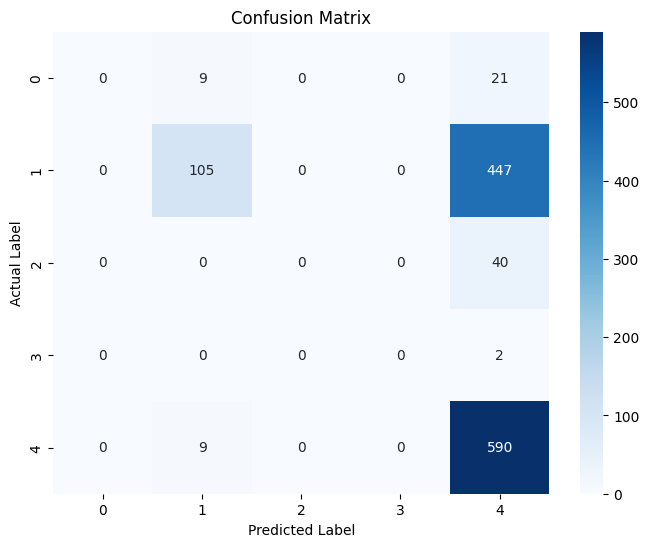

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # 'fmt='d' displays integers, 'annot=True' shows values in cells
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

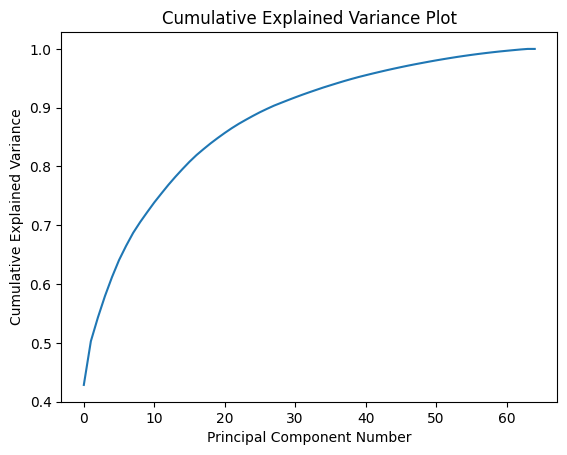

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Component Number")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot")
plt.show()

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)

40


In [ ]:
pca = PCA(n_components=40)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

In [ ]:
initial_feature_names = list(X)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(10)]
most_important_ev = [np.abs(pca.explained_variance_ratio_[i]) for i in range(10)]

most_important_names = [initial_feature_names[most_important[i]] for i in range(10)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(10)}

feature_importance_df = pd.DataFrame(dic.items())
feature_importance_df['2'] = most_important_ev
feature_importance_df.columns = ['Principal Component (PC)', 'Representative Codon', 'PC Explained Variance']
feature_importance_df

,Principal Component (PC),Representative Codon,PC Explained Variance
0,PC0,GCC,0.428408
1,PC1,AGG,0.074417
2,PC2,CGU,0.040369
3,PC3,AAC,0.036340
4,PC4,CGA,0.032319
5,PC5,UUG,0.028955
6,PC6,AGC,0.024134
7,PC7,CGA,0.022117
8,PC8,Ncodons,0.018435
9,PC9,Ncodons,0.016890


In [ ]:
rf = RandomForestClassifier(n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=False).fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         arc       0.84      0.53      0.65        30
         bct       0.94      0.97      0.96       552
         phg       0.92      0.60      0.73        40
         plm       0.00      0.00      0.00         2
         vrl       0.97      0.98      0.98       599

    accuracy                           0.95      1223
   macro avg       0.74      0.62      0.66      1223
weighted avg       0.95      0.95      0.95      1223



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


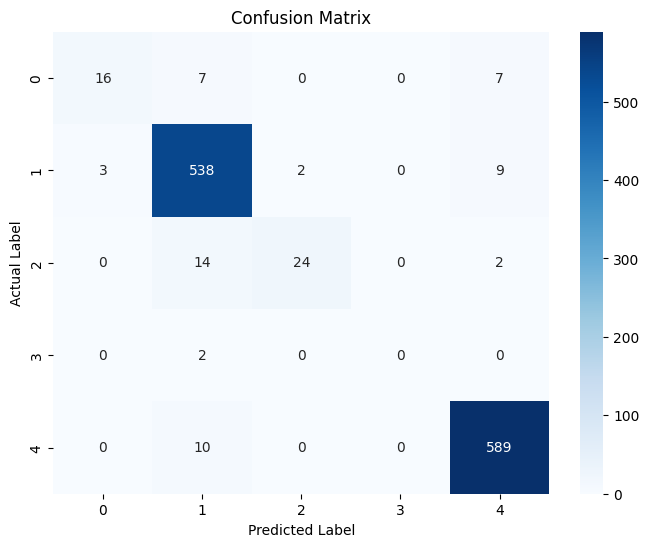

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # 'fmt='d' displays integers, 'annot=True' shows values in cells
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

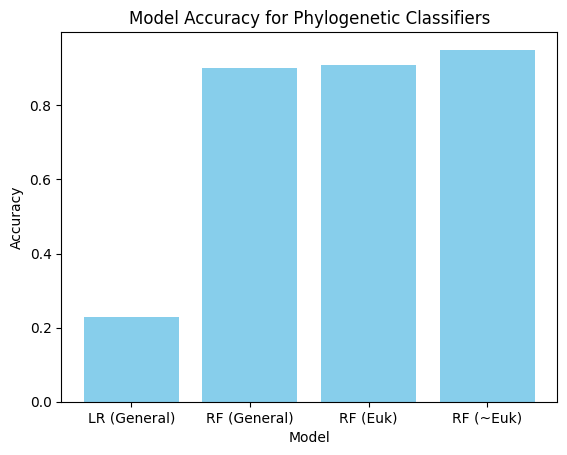

In [ ]:
# Sample data
categories = ['LR (General)', 'RF (General)', 'RF (Euk)', 'RF (~Euk)']
values = [.23, .90, .91, .95]

# Creating the bar plot
plt.bar(categories, values, color='skyblue')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Phylogenetic Classifiers')

# Displaying the plot
plt.show()